<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_tensorflow2/blob/main/6_ChatBot/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 작업공간 접근

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

data_in/   EDA.ipynb         preprocess.py        __pycache__/
data_out/  Preprocess.ipynb  preprocess_py.ipynb  seq2seq.ipynb


### Konlpy 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,515 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubunt

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   433k      0  0:00:03  0:00:03 --:--:--  680k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

## seq2seq.ipynb

### 모듈 불러오기

In [ ]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

### 시각화 함수

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### 학습 데이터 경로 설정

In [ ]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

### 랜덤 시드값 선언

In [ ]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

### 전처리된 데이터와 설정값 불러오기 및 데이터간 크기 동일 확인

In [ ]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [ ]:
print(len(index_inputs),  len(index_outputs), len(index_targets))

11823 11823 11823


### 모델 구성에 필요한 값 선언

In [ ]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 15
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

## 모델

## 인코더

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True, # 각 시퀀스마다 출력을 반환 할지 여부
                                       return_state=True,     # 마지막 상태 값의 반환 여부
                                       recurrent_initializer='glorot_uniform') # 초기값을 무엇으로 할지 선언
        # glorot_uniform : Glorot 또는 Xavier 초기화라고도 불리는 초기화 방법
        # 이전 노드와 다음 노드의 개수에 의존하는 방식
        # glorot_uniform 분포 or glorot_normal 분포 중에 선택

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

### 어텐션

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### TEST(tanh,softmax,np.array,reduce_sum)

### tanh

In [ ]:
a=[[[1,2,3],[1,3,2]],[[0.4,1,5],[5,1,0.4]]]
print(np.shape(a))
p=tf.nn.tanh(a)
p

(2, 2, 3)


<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[0.7615942 , 0.9640276 , 0.9950547 ],
        [0.7615942 , 0.9950547 , 0.9640276 ]],

       [[0.379949  , 0.7615942 , 0.99990916],
        [0.99990916, 0.7615942 , 0.379949  ]]], dtype=float32)>

### softmax

In [ ]:
p=[[[8.4],[10.6]],[[4.5],[4.6]]]
np.shape(p)

(2, 2, 1)

In [ ]:
tf.nn.softmax(p,axis=1)

<tf.Tensor: shape=(2, 2, 1), dtype=float32, numpy=
array([[[0.09975041],
        [0.90024954]],

       [[0.47502083],
        [0.5249791 ]]], dtype=float32)>

In [ ]:
tf.nn.softmax(p,axis=0)

<tf.Tensor: shape=(2, 2, 1), dtype=float32, numpy=
array([[[0.98015964],
        [0.9975274 ]],

       [[0.01984031],
        [0.00247262]]], dtype=float32)>

In [ ]:
tf.nn.softmax(p,axis=2)

<tf.Tensor: shape=(2, 2, 1), dtype=float32, numpy=
array([[[1.],
        [1.]],

       [[1.],
        [1.]]], dtype=float32)>

In [ ]:
p=[[[8.4,5.6],[10.6,5.6]],[[4.5,5.6],[4.6,5.6]]]
np.shape(p)

(2, 2, 2)

In [ ]:
tf.nn.softmax(p,axis=2)

<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.9426758 , 0.05732419],
        [0.9933072 , 0.00669285]],

       [[0.24973992, 0.7502601 ],
        [0.26894143, 0.73105854]]], dtype=float32)>

### np.array 연산

In [ ]:
a=np.array([[[1,2]],[[3,4]]])
b=np.array([[[5,6]],[[7,8]]])
a+b

array([[[ 6,  8]],

       [[10, 12]]])

In [ ]:
a=np.array([1,2])
b=np.array([[3,4],[5,6]])
a+b

array([[4, 6],
       [6, 8]])

In [ ]:
a=np.array([[1],[2]])
b=np.array([[3,4],[5,6]])
a+b

array([[4, 5],
       [7, 8]])

In [ ]:
a=np.array([[[1],[2],[3]]])
b=np.array([[[7,8,9],[10,11,12],[13,14,15]]])
print(a)
print(b)
a*b

[[[1]
  [2]
  [3]]]
[[[ 7  8  9]
  [10 11 12]
  [13 14 15]]]


array([[[ 7,  8,  9],
        [20, 22, 24],
        [39, 42, 45]]])

### tf.reduce_sum( axis=1)

In [ ]:
b=np.array([[[7,8,9],[10,11,12],[13,14,15]]])
print(b)
b=tf.reduce_sum(b,axis=1)
b 

[[[ 7  8  9]
  [10 11 12]
  [13 14 15]]]


<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[30, 33, 36]])>

In [ ]:
b=np.array([[[7,8,9],[10,11,12],[13,14,15]]])
b=tf.reduce_sum(b,axis=0)
b

<tf.Tensor: shape=(3, 3), dtype=int64, numpy=
array([[ 7,  8,  9],
       [10, 11, 12],
       [13, 14, 15]])>

In [ ]:
b=np.array([[[7,8,9],[10,11,12],[13,14,15]]])
b=tf.reduce_sum(b,axis=2)
b

<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[24, 33, 42]])>

---

In [ ]:
b=np.array([[[7,8,9],[10,11,12]],[[1,2,3],[4,5,6]]])
print(b)
b=tf.reduce_sum(b,axis=1)
b 

[[[ 7  8  9]
  [10 11 12]]

 [[ 1  2  3]
  [ 4  5  6]]]


<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[17, 19, 21],
       [ 5,  7,  9]])>

In [ ]:
b=np.array([[[7,8,9],[10,11,12]],[[1,2,3],[4,5,6]]])
print(b)
b=tf.reduce_sum(b,axis=0)
b 

[[[ 7  8  9]
  [10 11 12]]

 [[ 1  2  3]
  [ 4  5  6]]]


<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[ 8, 10, 12],
       [14, 16, 18]])>

In [ ]:
b=np.array([[[7,8,9],[10,11,12]],[[1,2,3],[4,5,6]]])
print(b)
b=tf.reduce_sum(b,axis=2)
b 

[[[ 7  8  9]
  [10 11 12]]

 [[ 1  2  3]
  [ 4  5  6]]]


<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[24, 33],
       [ 6, 15]])>

### tf.expand_dims 

 axis
 0(3차원 : -3)\
 1(2차원 : -2)\
 2(1차원 : -1)


In [ ]:
c=[[1,2,3,4]]
c=tf.expand_dims(c,axis=0)
c

<tf.Tensor: shape=(1, 1, 4), dtype=int32, numpy=array([[[1, 2, 3, 4]]], dtype=int32)>

In [ ]:
c=[[1,2,3,4]]
c=tf.expand_dims(c,axis=1)
c

<tf.Tensor: shape=(1, 1, 4), dtype=int32, numpy=array([[[1, 2, 3, 4]]], dtype=int32)>

In [ ]:
c=[[1,2,3,4]]
c=tf.expand_dims(c,axis=2)
c

<tf.Tensor: shape=(1, 4, 1), dtype=int32, numpy=
array([[[1],
        [2],
        [3],
        [4]]], dtype=int32)>

---

In [ ]:
c=[[1,2,3,4],[5,6,7,8]]
c=tf.expand_dims(c,axis=0)
c

<tf.Tensor: shape=(1, 2, 4), dtype=int32, numpy=
array([[[1, 2, 3, 4],
        [5, 6, 7, 8]]], dtype=int32)>

In [ ]:
c=[[1,2,3,4],[5,6,7,8]]
c=tf.expand_dims(c,axis=1)
c

<tf.Tensor: shape=(2, 1, 4), dtype=int32, numpy=
array([[[1, 2, 3, 4]],

       [[5, 6, 7, 8]]], dtype=int32)>

In [ ]:
c=[[1,2,3,4],[5,6,7,8]]
c=tf.expand_dims(c,axis=2)
c

<tf.Tensor: shape=(2, 4, 1), dtype=int32, numpy=
array([[[1],
        [2],
        [3],
        [4]],

       [[5],
        [6],
        [7],
        [8]]], dtype=int32)>

In [ ]:
c=[1]
tf.expand_dims(c,1)

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>

In [ ]:
import numpy as np
a=np.array([[1,2,3]])
a[0]

array([1, 2, 3])

In [ ]:
tf.argmax(a[0])

<tf.Tensor: shape=(), dtype=int64, numpy=2>

### tf.concat

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [ ]:
print(a[:,1])


[2 5 8]


In [ ]:
a=tf.expand_dims(a[:,1],axis=1)
a

<tf.Tensor: shape=(3, 1), dtype=int64, numpy=
array([[2],
       [5],
       [8]])>

In [ ]:
embedding=tf.keras.layers.Embedding(input_dim=10,output_dim=3)
output=embedding(a)
print(output)

tf.Tensor(
[[[ 0.02019851  0.04813669 -0.01945983]]

 [[-0.02738466  0.03100606 -0.04728745]]

 [[ 0.00344632 -0.04141901 -0.03678871]]], shape=(3, 1, 3), dtype=float32)


In [ ]:
b=np.array([[[1,2,3]],[[4,5,6]],[[7,8,9]]])   
# [[1,2,3],[4,5,6],[7,8,9]] : shape(3,3) 를 expand_dims(,axis=1) 한것
print(b,b.shape)

[[[1 2 3]]

 [[4 5 6]]

 [[7 8 9]]] (3, 1, 3)


In [ ]:
tf.concat([b,output],axis=-1) # axis=-1 == axis=2

<tf.Tensor: shape=(3, 1, 6), dtype=float32, numpy=
array([[[ 1.0000000e+00,  2.0000000e+00,  3.0000000e+00,  2.0198513e-02,
          4.8136685e-02, -1.9459832e-02]],

       [[ 4.0000000e+00,  5.0000000e+00,  6.0000000e+00, -2.7384663e-02,
          3.1006064e-02, -4.7287453e-02]],

       [[ 7.0000000e+00,  8.0000000e+00,  9.0000000e+00,  3.4463182e-03,
         -4.1419007e-02, -3.6788713e-02]]], dtype=float32)>

### tf.reshape

In [ ]:
a= np.array([[[1,2,3]],[[4,5,6]],[[7,8,9]]])
print(a,a.shape)
tf.reshape(a,(-1,a.shape[2]))

[[[1 2 3]]

 [[4 5 6]]

 [[7 8 9]]] (3, 1, 3)


<tf.Tensor: shape=(3, 3), dtype=int64, numpy=
array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])>

### list.append()

In [ ]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])   
b=list()
b.append(tf.dtypes.cast(a,tf.float32))
print(type(b))
print(b)
c=np.array([[4,5,6],[7,8,9],[10,11,12]])   
b.append(c)
b

<class 'list'>
[<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]], dtype=float32)>]


[<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]], dtype=float32)>, array([[ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])]

### tf.stack( , axis)

In [ ]:
d=tf.stack(b,axis=1)
d

<tf.Tensor: shape=(3, 2, 3), dtype=float32, numpy=
array([[[ 1.,  2.,  3.],
        [ 4.,  5.,  6.]],

       [[ 4.,  5.,  6.],
        [ 7.,  8.,  9.]],

       [[ 7.,  8.,  9.],
        [10., 11., 12.]]], dtype=float32)>

In [ ]:
type(d)

tensorflow.python.framework.ops.EagerTensor

### sparsecrossentropy

In [ ]:
import tensorflow as tf 
y_true = [[1, 2],[2,1]]
y_pred = [[[0.,1.,0.],[0.,0. ,1. ]],[[0.,0.,1.], [0., 1., 0.]]]

scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
a=scce(y_true, y_pred).numpy()
a

array([[0.55144477, 0.55144477],
       [0.55144477, 0.55144477]], dtype=float32)

In [ ]:
tf.reduce_mean(a)

<tf.Tensor: shape=(), dtype=float32, numpy=0.55144477>

### 디코더

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        x = self.fc(output)
        
        return x, state, attention_weights

In [ ]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [ ]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):    
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz) 
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz) 

    def call(self, x):
        inp, tar = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp  = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [ ]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
#model.run_eagerly = True

In [19]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/15
5320/5320 [==============================] - ETA: 0s - loss: 1.2640 - accuracy: 0.8565
Epoch 1: val_accuracy improved from -inf to 0.85494, saving model to ./data_out/seq2seq_kor/weights.h5
5320/5320 [==============================] - 880s 157ms/step - loss: 1.2640 - accuracy: 0.8565 - val_loss: 1.4565 - val_accuracy: 0.8549
Epoch 2/15
5320/5320 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 0.8571
Epoch 2: val_accuracy improved from 0.85494 to 0.85899, saving model to ./data_out/seq2seq_kor/weights.h5
5320/5320 [==============================] - 824s 155ms/step - loss: 1.0454 - accuracy: 0.8571 - val_loss: 1.5312 - val_accuracy: 0.8590
Epoch 3/15
5320/5320 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.8625
Epoch 3: val_accuracy improved from 0.85899 to 0.86563, saving model to ./data_out/seq2seq_kor/weights.h5
5320/5320 [==============================] - 823s 155ms/step - loss: 0.8212 - accuracy: 0.8625 - val_loss: 1.6316 - v

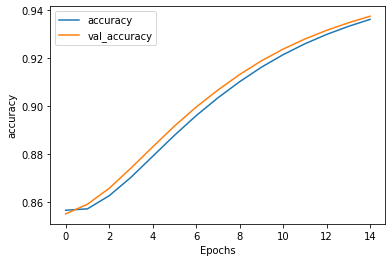

In [20]:
plot_graphs(history, 'accuracy')

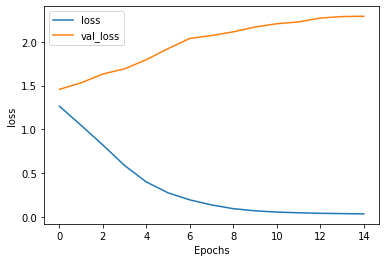

In [21]:
plot_graphs(history, 'loss')

In [22]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [23]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[13275  8248   336  2037]
평소에 필요한 것 생각해보세요


In [24]:
query = "재미없다"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[ 8847 12428 20489  5162  2047 14495 20431]
활기찬 사람을 만나보시면 생각이 바뀔 수도 있어요


In [27]:
query = "안녕"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[6717]
안녕하세요


In [28]:
query = "내일 월요일이다"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[18046 18606  3564  1060   584  3888]
날씨가 안 좋더라도 데이트는 성공적일 거예요


In [29]:
query = "재미있는 게임 없나?"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[ 1970  8567 15397]
재미있는 다른걸 찾아보세요


In [30]:
query = "어떤 운동을 하면 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)    
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[7795]
고생했어요
